# torchvision

In [87]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'
orig_img = Image.open(Path('/home/lab17/jupyter_home/Data/product_image/Training/image/35102_삼양사)건포도150G/35102_30_s_6.jpg'))
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

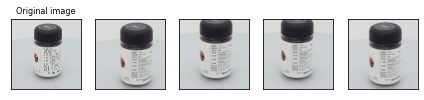

In [55]:
resize = T.Resize((256, 256))
cropper = T.RandomCrop(220)
crops = [cropper(resize(orig_img)) for _ in range(4)]
plot(crops)

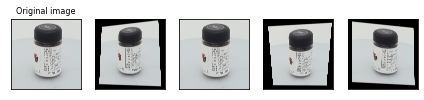

In [65]:
# distortion_scale : 왜곡 정도 (범위 0, 1 / 기본 0.5)
# p : 변환될 확률 (기본 0.5)
perspective_transformer = T.RandomPerspective(distortion_scale=0.3, p=0.8)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot(perspective_imgs)

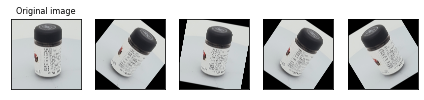

In [63]:
# affine_transfomer = T.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_transfomer = T.RandomAffine(degrees=(-45, 45), scale=(0.9, 1.0))
affine_imgs = [affine_transfomer(orig_img) for _ in range(4)]
plot(affine_imgs)

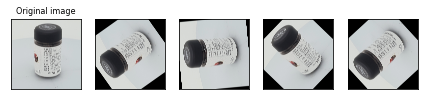

In [15]:
rotater = T.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(orig_img) for _ in range(4)]
plot(rotated_imgs)

- 360 도 까지 돌려도 될 것 같음

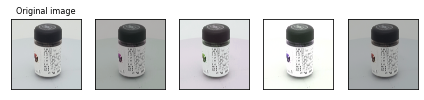

In [43]:
jitter = T.ColorJitter(brightness=.7, hue=.4)
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot(jitted_imgs)

In [ ]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((256, 256)),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    transforms.RandomCrop(224),
                    transforms.RandomPerspective(distortion_scale=0.3, p=0.8),
                    transforms.RandomAffine(degrees=(-45, 45), scale=(0.9, 1.0)),
                    transforms.RandomRotation(degrees=(0, 180)),
                    transforms.ColorJitter(brightness=.7, hue=.4),
                    ])

# Albumentation

In [51]:
!pip install -U albumentations

In [52]:
import numpy as np
import random
import os
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torch.autograd import Variable

import torchvision.models as models
from torchvision import transforms

In [82]:
import albumentations as A
import albumentations.pytorch

In [7]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    image_path = os.path.join(data_dir, 'image')
    label_path = os.path.join(data_dir, 'label')
    
    for product_name in os.listdir(image_path):
        product_path = os.path.join(image_path, product_name)
        if os.path.isdir(product_path):
            # get image path
            img_path_list.extend(glob(os.path.join(product_path, '*.jpg')))
            img_path_list.extend(glob(os.path.join(product_path, '*.png')))
            label = list(product_name[:5])
            
            # get label
            label_list.append(''.join(label))
                
    return img_path_list, label_list

In [8]:
img_list, label_list = get_train_data('/home/lab17/jupyter_home/Data/product_image/Training/')

In [9]:
def data_blanced(img, label):
    x = []
    y = []
    
    for i in range(len(label)):
        _img = img[(i * 114): ((i + 1) * 114)]
        _label = label[i]
        
        for img_product in _img:
            x.append(img_product)
            y.append(_label)
            
    return x, y

In [10]:
x, y = data_blanced(img_list, label_list)

In [11]:
le = preprocessing.LabelEncoder()
targets = le.fit_transform(y)
targets = torch.as_tensor(targets)

In [12]:
len(targets)

8664

In [13]:
one_hot_y = F.one_hot(targets)

In [14]:
one_hot_y.shape

torch.Size([8664, 76])

In [15]:
def get_valid_data(data_dir):
    img_valid_list = []
    label_valid_list = []
    
    image_path = os.path.join(data_dir, 'image')
    label_path = os.path.join(data_dir, 'label')
    
    for product_name in os.listdir(image_path):
        product_path = os.path.join(image_path, product_name)
        if os.path.isdir(product_path):
            # get image path
            img_valid_list.extend(glob(os.path.join(product_path, '*.jpg')))
            img_valid_list.extend(glob(os.path.join(product_path, '*.png')))
            label = list(product_name[:5])
            
            # get label
            label_valid_list.append(''.join(label))
                
    return img_valid_list, label_valid_list

In [16]:
def valid_data_blanced(img, label):
    x = []
    y = []
    
    for i in range(len(label)):
        _img = img[(i * 15): ((i + 1) * 15)]
        _label = label[i]
        
        for img_product in _img:
            x.append(img_product)
            y.append(_label)
            
    return x, y

In [17]:
img_valid_list, label_valid_list = get_valid_data('/home/lab17/jupyter_home/Data/product_image/Validation/')

In [18]:
x_valid, y_valid = valid_data_blanced(img_valid_list, label_valid_list)

In [19]:
len(label_valid_list)

76

In [20]:
le2 = preprocessing.LabelEncoder()
targets_y = le2.fit_transform(y_valid)
targets_y = torch.as_tensor(targets_y)
one_hot_valid_y = F.one_hot(targets_y)

In [21]:
one_hot_valid_y.shape

torch.Size([1140, 76])

## -- 여기부터 수정 --

In [83]:
class AlbumentationsCustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.train_mode:
#             image = image.astype(np.int16)
            augmented = self.transforms(image=image)
            image = augmented['image']
            label = self.label_list[index]
            return image, label
        else:
            image = self.transforms(image)
            return image
    
    def __len__(self):
        return len(self.img_path_list)

In [84]:
'''
train_transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    transforms.RandomCrop(224),
                    transforms.RandomPerspective(distortion_scale=0.3, p=0.8),
                    transforms.RandomAffine(degrees=(-45, 45), scale=(0.9, 1.0)),
                    transforms.RandomRotation(degrees=(0, 180)),
                    transforms.ColorJitter(brightness=.7, hue=.4),
                    transforms.ToTensor(),
                    ])
'''

A_train_transform = albumentations.Compose([
                                    A.Resize(256, 256),
#                                     albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                    A.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225]),
                                    A.RandomCrop(224, 224),
                                    A.RandomBrightness(limit=1.1, p=0.5),
                                    A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                                    A.pytorch.transforms.ToTensorV2(),
                                ])
A_test_transform = transforms.Compose([
                                    A.Resize(256, 256),
#                                     albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                    A.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225]),    
                                    A.pytorch.transforms.ToTensorV2()
                                ])

In [85]:
A_train_dataset = AlbumentationsCustomDataset(x, one_hot_y, train_mode=True, transforms=A_train_transform)
A_train_loader = DataLoader(A_train_dataset, batch_size = 32, shuffle=True, num_workers=0, collate_fn=None)

A_vali_dataset = AlbumentationsCustomDataset(x_valid, one_hot_valid_y, train_mode=True, transforms=A_test_transform)
A_vali_loader = DataLoader(A_vali_dataset, batch_size = 5, shuffle=False, num_workers=0, collate_fn=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


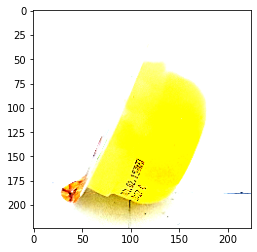

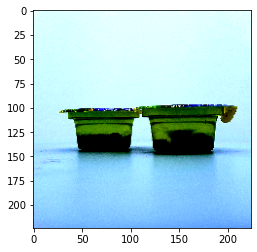

In [86]:
import matplotlib.pyplot as plt

def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
def process():
    for batch_idx, (inputs, targets) in enumerate(A_train_loader):
        custom_imshow(inputs[0])
        if batch_idx==1:break

process()

# Albumentation EDA

In [106]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']
        return image, label

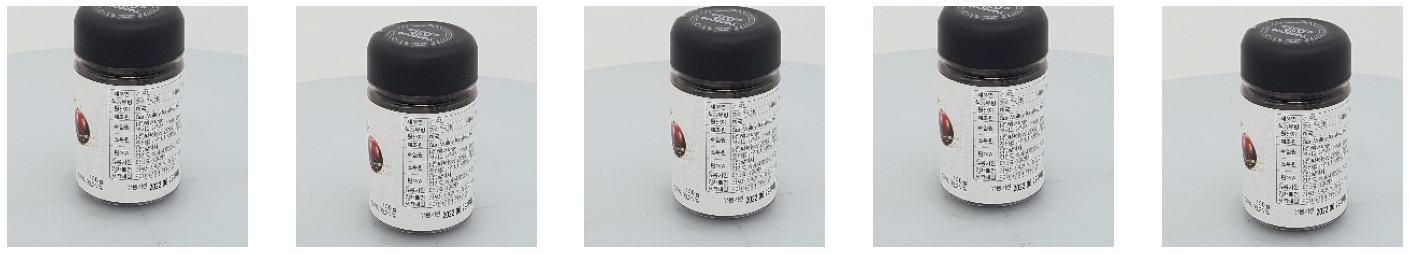

In [107]:
A_train_transform = albumentations.Compose([
                                    A.Resize(256, 256),
#                                     albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#                                     A.Normalize(mean=[0.485, 0.456, 0.406],
#                                                 std=[0.229, 0.224, 0.225]),
                                    A.RandomCrop(224, 224),
#                                     A.RandomBrightness(limit=1.1, p=0.5),
#                                     A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                                    A.pytorch.transforms.ToTensorV2(),
                                ])

albumentations_dataset = AlbumentationsDataset(
    file_paths=['/home/lab17/jupyter_home/Data/product_image/Training/image/35102_삼양사)건포도150G/35102_30_s_6.jpg'],
    labels=[1],
    transform=A_train_transform,
)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
    ax[i].axis('off')

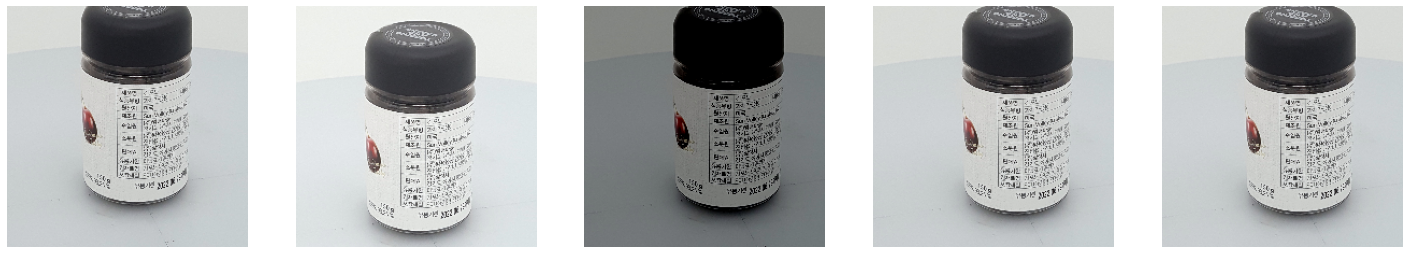

In [118]:
A_train_transform = albumentations.Compose([
                                    A.Resize(256, 256),
#                                     albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#                                     A.Normalize(mean=[0.485, 0.456, 0.406],
#                                                 std=[0.229, 0.224, 0.225]),
                                    A.RandomCrop(224, 224),
                                    A.RandomBrightness(limit=0.4, p=0.5),
#                                     A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                                    A.pytorch.transforms.ToTensorV2(),
                                ])

albumentations_dataset = AlbumentationsDataset(
    file_paths=['/home/lab17/jupyter_home/Data/product_image/Training/image/35102_삼양사)건포도150G/35102_30_s_6.jpg'],
    labels=[1],
    transform=A_train_transform,
)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
    ax[i].axis('off')

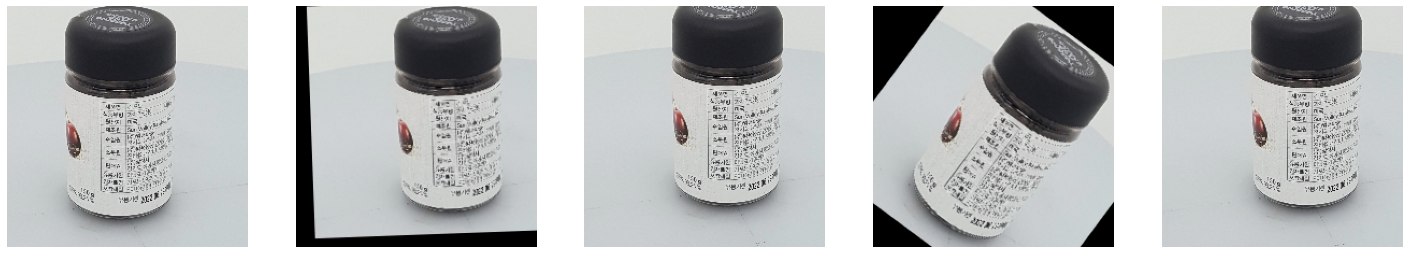

In [125]:
A_train_transform = albumentations.Compose([
                                    A.Resize(256, 256),
#                                     albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#                                     A.Normalize(mean=[0.485, 0.456, 0.406],
#                                                 std=[0.229, 0.224, 0.225]),
                                    A.RandomCrop(224, 224),
#                                     A.RandomBrightness(limit=0.4, p=0.5),
#                                     A.OneOf([
#                                              # shift, scale, rotate 를 무작위로 적용합니다.
#                                              A.ShiftScaleRotate(rotate_limit=90, p=0.5, border_mode=cv2.BORDER_CONSTANT),
#                                              # affine 변환
#                                              A.IAAAffine(shear=15, p=0.5, mode='constant')
#                                     ], p=1.0),
                                    A.ShiftScaleRotate(rotate_limit=90, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                                    A.pytorch.transforms.ToTensorV2(),
                                ])

albumentations_dataset = AlbumentationsDataset(
    file_paths=['/home/lab17/jupyter_home/Data/product_image/Training/image/35102_삼양사)건포도150G/35102_30_s_6.jpg'],
    labels=[1],
    transform=A_train_transform,
)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
    ax[i].axis('off')

# -- 최종은아니지만, 여기까지 확인된 코드

In [ ]:
A_train_transform = albumentations.Compose([
                                    A.Resize(256, 256),
                                    albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#                                     A.Normalize(mean=[0.485, 0.456, 0.406],
#                                                 std=[0.229, 0.224, 0.225]),
                                    A.RandomCrop(224, 224),
                                    A.RandomBrightness(limit=0.4, p=0.5),
                                    A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                                    A.pytorch.transforms.ToTensorV2(),
                                ])
